In [1]:
#librairie utilisée
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Le fichier HEART DISEASE contient des informations et des résultats médicaux concernant des patients. La variable TARGET indique la présence (1) ou non (0) d'une maladie cardiage chez le patient.
Le principal objectif est de prédire la présence ou non d'une maladie cardiaque chez un patient.

EXPLORATION DU JEU DE DONNEES

In [2]:
#lecture du fichier
df=pd.read_csv("heart_disease.csv.csv", index_col=0, sep=',')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
ID,,,,,,,,,,,,,,
1012,63,Male,3,145.0,233.0,1,0,150.0,0.0,2.3,0,0.0,1,1.0
1264,37,Male,2,130.0,250.0,0,1,187.0,0.0,3.5,0,0.0,2,1.0
1217,41,Female,1,130.0,204.0,0,0,NaN,0.0,1.4,2,0.0,2,1.0
1300,56,Male,1,120.0,236.0,0,1,178.0,0.0,0.8,2,0.0,2,1.0
1049,57,Female,0,120.0,354.0,0,1,163.0,1.0,0.6,2,0.0,2,1.0


In [3]:
#Info sur le dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1012 to 1126
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    int64  
 3   trestbps  302 non-null    float64
 4   chol      300 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        300 non-null    float64
 12  thal      303 non-null    int64  
 13  target    300 non-null    float64
dtypes: float64(7), int64(6), object(1)
memory usage: 35.5+ KB


In [4]:
#présence de duplicata et/ou valeurs manquantes
print('Duplicata : ', df.duplicated().sum())
print('Valeurs manquantes:', df.isna().sum())
print(df.shape)

Duplicata :  1
Valeurs manquantes: age         0
sex         0
cp          0
trestbps    1
chol        3
fbs         0
restecg     0
thalach     6
exang       6
oldpeak     0
slope       0
ca          3
thal        0
target      3
dtype: int64
(303, 14)


Quelques visualisations :

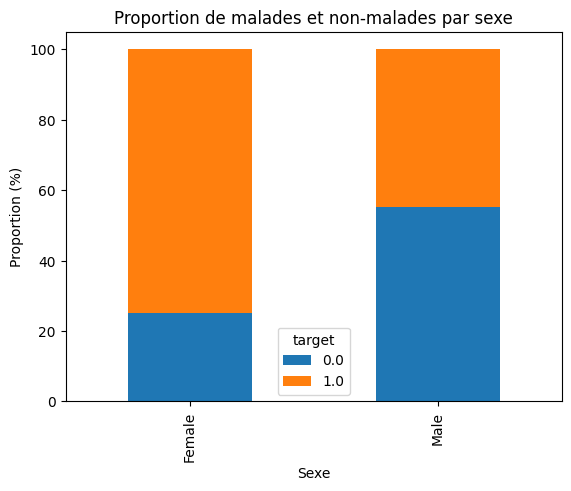

In [5]:
#Proportion de malades et non malades selon le sexe des patients : Disparité de Santé
proportion=df.groupby('sex')['target'].value_counts(normalize=True).mul(100).rename('Proportion')

proportion.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Sexe')
plt.ylabel('Proportion (%)')
plt.title('Proportion de malades et non-malades par sexe')
plt.show()

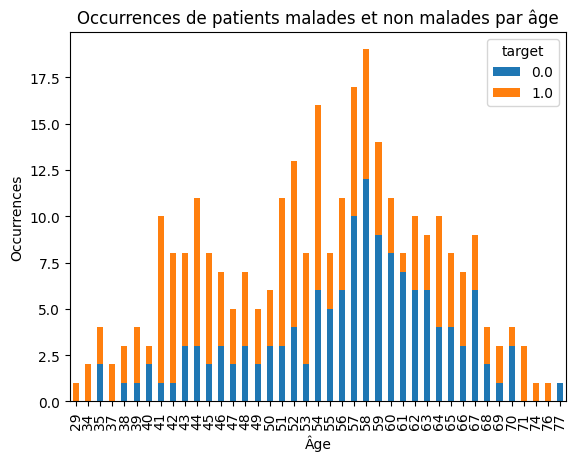

In [6]:
#Occurences de patients malades et non malades selon l'âge : tendance générale selon certaine tranche d'age :
result = df.groupby(['age', 'target']).size().unstack().fillna(0)
result.plot(kind='bar', stacked=True)
plt.xlabel('Âge')
plt.ylabel('Occurrences')
plt.title('Occurrences de patients malades et non malades par âge')
plt.show()

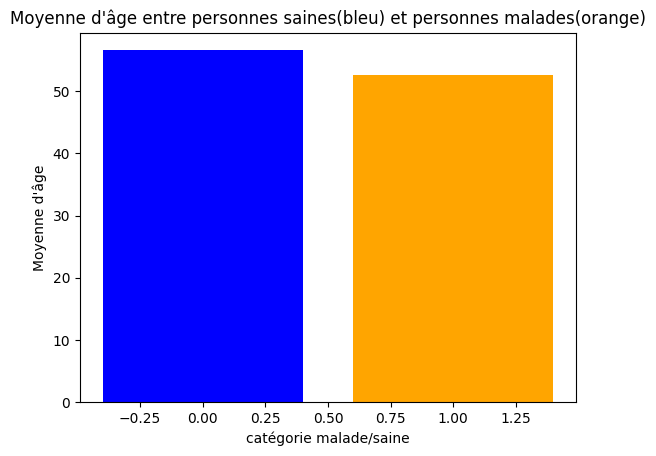

In [7]:
#moyenne d'age entre personnes saines et personnes malades : l'âge est-il un facteur de risque ?
moy=df.groupby('target')['age'].mean()
plt.bar(moy.index, moy, color=['blue', 'orange'])
plt.title("Moyenne d'âge entre personnes saines(bleu) et personnes malades(orange)")
plt.xlabel("catégorie malade/saine")
plt.ylabel("Moyenne d'âge")
plt.show()

PREPARATION DU JEU DE DONNEES

In [9]:
#Exploration des valeurs uniques des contenus des colonnes
for col in df.select_dtypes(include=['int', 'float']).columns:
    print(df[col].unique())

[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77]
[3 2 1 0]
[145. 130. 120. 140. 172. 150. 110. 135. 160. 105. 125. 142. 155. 104.
 138. 128. 108. 134. 122. 115. 118. 100. 124.  94. 112. 102. 152. 101.
 132. 148. 178. 129. 180. 136. 126. 106. 156. 170. 146. 117. 200. 165.
 174. 192. 144. 123. 154. 114. 164.  nan]
[233. 250. 204. 236. 354. 192. 294. 263. 199. 168. 239. 275. 266. 211.
 283. 219. 340. 226. 247. 234. 243. 302. 212. 175. 417. 197. 198. 177.
 273. 213. 304. 232. 269. 360. 308. 245. 208. 264. 321. 325. 235. 257.
 216. 256. 231. 141. 252. 201. 222. 260. 182. 303. 265. 309. 186. 203.
 183. 220. 209. 258. 227. 261. 221. 205.  nan 318. 298. 564. 277. 214.
 248. 255. 207. 223. 288. 160. 394. 315. 246. 244. 270. 195. 240. 196.
 254. 126. 313. 262. 215. 193. 271. 268. 267. 210. 295. 306. 178. 242.
 180. 228. 149. 278. 253. 342. 157. 286. 229. 284. 224. 206. 167. 230.
 335. 276. 353. 225. 330. 290. 172. 305. 

In [10]:
#Suppression des  duplicatas
df=df.drop_duplicates(subset=df.columns)
df.shape

(302, 14)

In [11]:
#Gestion des valeurs manquantes par colonne
df.isna().sum()

age         0
sex         0
cp          0
trestbps    1
chol        3
fbs         0
restecg     0
thalach     6
exang       6
oldpeak     0
slope       0
ca          3
thal        0
target      3
dtype: int64

In [12]:
#Gestion des valeurs manquantes non labélisées : suppression des valeurs manquantes de la variable cible:
df=df.dropna(subset=['target'])

In [13]:
#Gestion des valeurs manquantes de colonnes qui prennent un nombre fini de modalités:
df['ca']=df['ca'].fillna(df['ca'].mode()[0])
df['exang']=df['exang'].fillna(df['exang'].mode()[0])

In [14]:
#Gestion des valeurs manquantes des autres variables numériques:  remplacement par la médiane
df=df.fillna(df.median())

<ipython-input-14-cf5f9733dd1c>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df=df.fillna(df.median())


In [15]:
#vérification
df.isna().sum().sum()

0

In [16]:
#recodage de données (pour les rendre compatible avec les algo) : variable sex : deux modalités : 'Male' et'Female'
df['sex']=df['sex'].replace(to_replace=['Male', 'Female'], value=[0,1])

In [17]:
#Gestion de valeur abberrante : variable Thalach : 19500, il semblerait que la valeur serait 195 (observation des valeurs uniques)
df['thalach']=df['thalach'].replace(to_replace =[19500.], value=[195.])

MODELISATION

In [18]:
#Séparation du jeu de données :
X = df.drop('target', axis=1)
y = df['target']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
#création de la pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())])
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf]

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True))])

pipeline_nb = Pipeline([
    ('classifier', GaussianNB())])

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier())])
#Liste pipeline
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svm, pipeline_nb, pipeline_mlp]

#Exécution
for pipeline in pipelines:
    # Entraînement du modèle sur les données d'entraînement
    pipeline.fit(X_train, y_train)

    # Prédiction sur les données de test
    y_pred_test = pipeline.predict(X_test)

    # Prédiction sur les données d'entraînement
    y_pred_train = pipeline.predict(X_train)

    # Calcul du score d'exactitude sur les données de test et d'entraînement
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Obtention du nom du modèle de classification
    classifier_name = pipeline.named_steps['classifier'].__class__.__name__

    print(f"{classifier_name}")
    print(f"Score sur les données d'entraînement : {accuracy_train}")
    print(f"Score sur les données de test : {accuracy_test}")
    print()


LogisticRegression
Score sur les données d'entraînement : 0.8516746411483254
Score sur les données de test : 0.8444444444444444

DecisionTreeClassifier
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.7444444444444445

RandomForestClassifier
Score sur les données d'entraînement : 1.0
Score sur les données de test : 0.8222222222222222

SVC
Score sur les données d'entraînement : 0.9090909090909091
Score sur les données de test : 0.8111111111111111

GaussianNB
Score sur les données d'entraînement : 0.84688995215311
Score sur les données de test : 0.8555555555555555

MLPClassifier
Score sur les données d'entraînement : 0.8755980861244019
Score sur les données de test : 0.8222222222222222



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


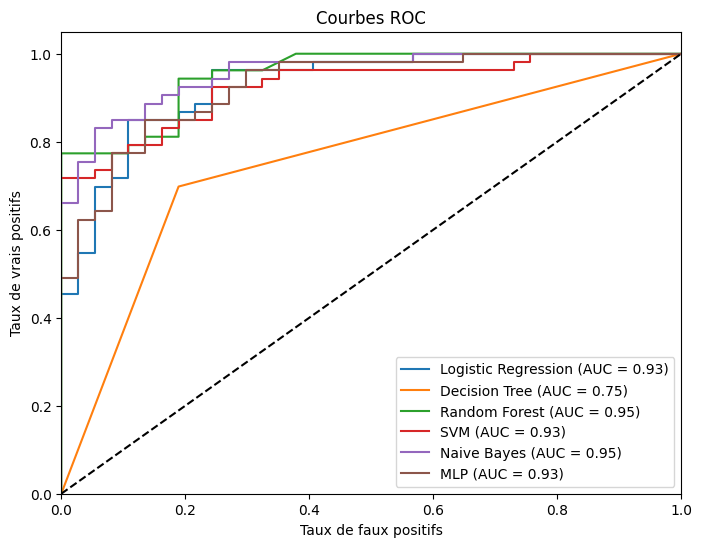

In [21]:
#Evaluation graphique des performances de chaque modèle en terme de spécificité (taux de faux positifs) et de sensibilité (taux de vrais positifs)
# Liste des noms des modèles
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes', 'MLP']

# Liste des modèles
models = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svm, pipeline_nb, pipeline_mlp]

# Courbes ROC (Receiver Operating Characteristic) et calculer l'Aire sous la courbe (AUC) pour chaque modèle
plt.figure(figsize=(8, 6))
for model, name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()